In [1]:
import pickle
with open(r'D:\ucl\pyssem\scenario-properties.pkl', 'rb') as file:
    scenario_properties = pickle.load(file)

from utils.drag.drag import JB2008_dens_func

In [2]:
# create a list of random decimal between 0 and 100
import random
import pandas as pd
import sympy as sp
from scipy.integrate import solve_ivp
random.seed(0)
random_numbers = [random.uniform(0, 100) for i in range(1000)]

h = scenario_properties.R0_km
scen_time_dates = scenario_properties.scen_times_dates
start_date = scenario_properties.start_date
end_date = scenario_properties.start_date + pd.DateOffset(years=scenario_properties.simulation_duration)
num_steps = scenario_properties.steps

In [11]:
import os
import json
import numpy as np
import pandas as pd
from scipy.spatial import KDTree

# Pre-load and preprocess density data
def preload_density_data(file_path):
    with open(file_path, 'r') as file:
        density_data = json.load(file)
    return density_data

# Precompute date mapping for given t values and date range
def precompute_date_mapping(start_date, end_date, num_points=101):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    total_days = (end_date - start_date).days
    dates = [start_date + pd.to_timedelta(i / (num_points - 1) * total_days, unit='d') for i in range(num_points)]
    date_mapping = [date.strftime('%Y-%m') for date in dates]
    return date_mapping

# Precompute nearest altitude mapping
def precompute_nearest_altitudes(available_altitudes, max_query=2000, resolution=1):
    altitude_tree = KDTree(np.array(available_altitudes).reshape(-1, 1))
    altitude_mapping = {}
    for alt in range(0, max_query + resolution, resolution):
        _, idx = altitude_tree.query([[alt]])
        nearest_alt = available_altitudes[idx[0]]
        altitude_mapping[alt] = nearest_alt
    return altitude_mapping

# Load data
density_data = preload_density_data(r'D:\ucl\pyssem\pyssem\utils\drag\dens_highvar_2000_dens_highvar_2000_lookup.json')
date_mapping = precompute_date_mapping(scenario_properties.start_date, end_date)
available_altitudes = list(map(int, list(density_data['2020-03'].keys())))
available_altitudes.sort()
nearest_altitude_mapping = precompute_nearest_altitudes(available_altitudes)

# Optimized function to use in solve_ivp
def JB2008_dens_func(t, h, density_data, date_mapping, nearest_altitude_mapping):
    """
    Calculate density at various altitudes based on a percentage through a time range
    using precomputed data for efficiency.

    :param t: Percentage of the way through the simulation, between 0 and 100
    :param h: List of altitudes for which densities are required
    :param density_data: Preloaded density data
    :param date_mapping: Precomputed date mapping
    :param nearest_altitude_mapping: Precomputed nearest altitude mapping
    :return: List of densities corresponding to each altitude in h
    """
    # Compute index for t assuming t is between 0 and 100
    t_index = int(t)
    target_date_str = date_mapping[t_index]

    # Check if the target date is in the dataset
    if target_date_str not in density_data:
        raise ValueError(f"No data available for {target_date_str}")

    # Compute densities for the requested altitudes
    density_values = []
    for alt in h:
        query_alt = min(alt, max(nearest_altitude_mapping.keys()))
        nearest_alt = nearest_altitude_mapping[query_alt]
        density_values.append(density_data[target_date_str][str(nearest_alt)])

    # convert to np.array
    density_values = np.array(density_values)
    print(len(density_values))

    return density_values

In [4]:
scenario_properties.density_model

<function utils.drag.drag.static_exp_dens_func(t, h, species, scen_properties)>

In [65]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

#equations_flattened = [scenario_properties.equations[i, j] for j in range(scenario_properties.equations.cols) for i in range(scenario_properties.equations.rows)]
#drag_flattened = [scenario_properties.full_drag[i, j] for j in range(scenario_properties.full_drag.cols) for i in range(scenario_properties.full_drag.rows)]
drag_upper_flattened = [scenario_properties.drag_term_upper[i, j] for j in range(scenario_properties.drag_term_upper.cols) for i in range(scenario_properties.drag_term_upper.rows)]
drag_current_flattened = [scenario_properties.drag_term_cur[i, j] for j in range(scenario_properties.drag_term_cur.cols) for i in range(scenario_properties.drag_term_cur.rows)]
#pmd_flattened = [scenario_properties.full_Cdot_PMD[i, j] for j in range(scenario_properties.full_Cdot_PMD.cols) for i in range(scenario_properties.full_Cdot_PMD.rows)]
#collisions_flattened = [scenario_properties.full_coll[i, j] for j in range(scenario_properties.full_coll.cols) for i in range(scenario_properties.full_coll.rows)]

# Convert equations to lambda functions
#equations = [sp.lambdify(symbols, eq, 'numpy') for eq in equations_flattened]
drag_upper_lamd = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_upper_flattened]
drag_cur_lamd = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_current_flattened]
# full_drag = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_flattened]
#full_pmd = [sp.lambdify(symbols, eq, 'numpy') for eq in pmd_flattened]
#full_coll = [sp.lambdify(symbols, eq, 'numpy') for eq in collisions_flattened]

full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [73]:
combined_drag_expressions = []
for i in range(scenario_properties.drag_term_upper.rows):
    for j in range(scenario_properties.drag_term_upper.cols):
        upper_expr = scenario_properties.drag_term_upper[i, j]
        current_expr = scenario_properties.drag_term_cur[i, j]
        
        # Combine the expressions by adding them
        combined_expr = upper_expr + current_expr
        
        # Append the combined expression to the list
        combined_drag_expressions.append(combined_expr)

combined_drag_expressions_lamd = [sp.lambdify(symbols, eq, 'numpy') for eq in combined_drag_expressions]

In [37]:
drag_upper_lamd

[<function _lambdifygenerated(Su_260kg_1, Su_260kg_2, Su_260kg_3, Su_260kg_4, Su_260kg_5, Su_260kg_6, Su_260kg_7, Su_260kg_8, Su_260kg_9, Su_260kg_10, Su_260kg_11, Su_260kg_12, Su_260kg_13, Su_260kg_14, Su_260kg_15, Su_260kg_16, Su_260kg_17, Su_260kg_18, Su_260kg_19, Su_260kg_20, Su_260kg_21, Su_260kg_22, Su_260kg_23, Su_260kg_24, Su_260kg_25, Su_260kg_26, Su_260kg_27, Su_260kg_28, Su_260kg_29, Su_260kg_30, Su_260kg_31, Su_260kg_32, Su_260kg_33, Su_260kg_34, Su_260kg_35, Su_260kg_36, Su_260kg_37, Su_260kg_38, Su_260kg_39, Su_260kg_40, Su_473kg_1, Su_473kg_2, Su_473kg_3, Su_473kg_4, Su_473kg_5, Su_473kg_6, Su_473kg_7, Su_473kg_8, Su_473kg_9, Su_473kg_10, Su_473kg_11, Su_473kg_12, Su_473kg_13, Su_473kg_14, Su_473kg_15, Su_473kg_16, Su_473kg_17, Su_473kg_18, Su_473kg_19, Su_473kg_20, Su_473kg_21, Su_473kg_22, Su_473kg_23, Su_473kg_24, Su_473kg_25, Su_473kg_26, Su_473kg_27, Su_473kg_28, Su_473kg_29, Su_473kg_30, Su_473kg_31, Su_473kg_32, Su_473kg_33, Su_473kg_34, Su_473kg_35, Su_473kg_36, 

In [6]:
scenario_properties.time_dep_density = True

In [74]:
from utils.simulation.scen_properties import population_shell
x0_flattened = scenario_properties.x0.T.values.flatten()
times = np.array(scenario_properties.scen_times)

# def population_shell(t, N, full_lambda, equations):
#     print(f"Time: {t}")
#     dN_dt = np.zeros_like(N)

#     if scenario_properties.time_dep_density:
#         # Get density values for the current time step
#         rho = JB2008_dens_func(t, h, density_data, date_mapping, nearest_altitude_mapping)

#         rho = np.delete(rho, -1)
#         rho = np.repeat(rho, scenario_properties.species_length)

#         if len(rho) != len(N):
#             raise ValueError("Mismatch in the length of rho and N arrays")

#         for i in range(len(N)):
#             # Apply drag from the shell below unless it's the first shell
#             if i > 0:
#                 dN_dt[i] += drag_cur_lamd[i](*N) * rho[i]
            
#             # Apply drag to the shell above unless it's the last shell
#             if i < len(N) - 1:
#                 dN_dt[i] -= drag_upper_lamd[i](*N) * rho[i + 1]

#             if full_lambda[i] is not None:
#                 increase = np.interp(t, times, full_lambda[i])
#                 dN_dt[i] += 0 if np.isnan(increase) else increase
            
#             dN_dt[i] += equations[i](*N)

#     return dN_dt

def population_shell(t, N, full_lambda, equations):
    print(f"Time: {t}")
    dN_dt = np.zeros_like(N)

    if scenario_properties.time_dep_density:
        rho = JB2008_dens_func(t, h, density_data, date_mapping, nearest_altitude_mapping)
        rho = np.delete(rho, -1)
        rho = np.repeat(rho, scenario_properties.species_length)

        if len(rho) != len(N):
            raise ValueError("Mismatch in the length of rho and N arrays")

        # Vectorized application of drag terms
        for i in range(len(N)):
            # Check for proper alignment of rho if necessary
            dN_dt[i] += combined_drag_expressions_lamd[i % scenario_properties.species_length](*N) * rho[i]

            if full_lambda[i] is not None:
                increase = np.interp(t, times, full_lambda[i])
                dN_dt[i] += 0 if np.isnan(increase) else increase
            
            dN_dt[i] += eq_func(*N)

    for i, eq_func in enumerate(equations):
        

    return dN_dt

output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, 
                    args=(full_lambda_flattened, equations), 
                    t_eval=scenario_properties.scen_times, method='BDF')

Time: 0.0


TypeError: _lambdifygenerated() missing 239 required positional arguments: 'Su_260kg_2', 'Su_260kg_3', 'Su_260kg_4', 'Su_260kg_5', 'Su_260kg_6', 'Su_260kg_7', 'Su_260kg_8', 'Su_260kg_9', 'Su_260kg_10', 'Su_260kg_11', 'Su_260kg_12', 'Su_260kg_13', 'Su_260kg_14', 'Su_260kg_15', 'Su_260kg_16', 'Su_260kg_17', 'Su_260kg_18', 'Su_260kg_19', 'Su_260kg_20', 'Su_260kg_21', 'Su_260kg_22', 'Su_260kg_23', 'Su_260kg_24', 'Su_260kg_25', 'Su_260kg_26', 'Su_260kg_27', 'Su_260kg_28', 'Su_260kg_29', 'Su_260kg_30', 'Su_260kg_31', 'Su_260kg_32', 'Su_260kg_33', 'Su_260kg_34', 'Su_260kg_35', 'Su_260kg_36', 'Su_260kg_37', 'Su_260kg_38', 'Su_260kg_39', 'Su_260kg_40', 'Su_473kg_1', 'Su_473kg_2', 'Su_473kg_3', 'Su_473kg_4', 'Su_473kg_5', 'Su_473kg_6', 'Su_473kg_7', 'Su_473kg_8', 'Su_473kg_9', 'Su_473kg_10', 'Su_473kg_11', 'Su_473kg_12', 'Su_473kg_13', 'Su_473kg_14', 'Su_473kg_15', 'Su_473kg_16', 'Su_473kg_17', 'Su_473kg_18', 'Su_473kg_19', 'Su_473kg_20', 'Su_473kg_21', 'Su_473kg_22', 'Su_473kg_23', 'Su_473kg_24', 'Su_473kg_25', 'Su_473kg_26', 'Su_473kg_27', 'Su_473kg_28', 'Su_473kg_29', 'Su_473kg_30', 'Su_473kg_31', 'Su_473kg_32', 'Su_473kg_33', 'Su_473kg_34', 'Su_473kg_35', 'Su_473kg_36', 'Su_473kg_37', 'Su_473kg_38', 'Su_473kg_39', 'Su_473kg_40', 'Dummy_38515', 'Dummy_38504', 'Dummy_38493', 'Dummy_38482', 'Dummy_38480', 'Dummy_38479', 'Dummy_38478', 'Dummy_38477', 'Dummy_38476', 'Dummy_38514', 'Dummy_38513', 'Dummy_38512', 'Dummy_38511', 'Dummy_38510', 'Dummy_38509', 'Dummy_38508', 'Dummy_38507', 'Dummy_38506', 'Dummy_38505', 'Dummy_38503', 'Dummy_38502', 'Dummy_38501', 'Dummy_38500', 'Dummy_38499', 'Dummy_38498', 'Dummy_38497', 'Dummy_38496', 'Dummy_38495', 'Dummy_38494', 'Dummy_38492', 'Dummy_38491', 'Dummy_38490', 'Dummy_38489', 'Dummy_38488', 'Dummy_38487', 'Dummy_38486', 'Dummy_38485', 'Dummy_38484', 'Dummy_38483', 'Dummy_38481', 'Dummy_38475', 'Dummy_38464', 'Dummy_38453', 'Dummy_38442', 'Dummy_38440', 'Dummy_38439', 'Dummy_38438', 'Dummy_38437', 'Dummy_38436', 'Dummy_38474', 'Dummy_38473', 'Dummy_38472', 'Dummy_38471', 'Dummy_38470', 'Dummy_38469', 'Dummy_38468', 'Dummy_38467', 'Dummy_38466', 'Dummy_38465', 'Dummy_38463', 'Dummy_38462', 'Dummy_38461', 'Dummy_38460', 'Dummy_38459', 'Dummy_38458', 'Dummy_38457', 'Dummy_38456', 'Dummy_38455', 'Dummy_38454', 'Dummy_38452', 'Dummy_38451', 'Dummy_38450', 'Dummy_38449', 'Dummy_38448', 'Dummy_38447', 'Dummy_38446', 'Dummy_38445', 'Dummy_38444', 'Dummy_38443', 'Dummy_38441', 'N_260kg_1', 'N_260kg_2', 'N_260kg_3', 'N_260kg_4', 'N_260kg_5', 'N_260kg_6', 'N_260kg_7', 'N_260kg_8', 'N_260kg_9', 'N_260kg_10', 'N_260kg_11', 'N_260kg_12', 'N_260kg_13', 'N_260kg_14', 'N_260kg_15', 'N_260kg_16', 'N_260kg_17', 'N_260kg_18', 'N_260kg_19', 'N_260kg_20', 'N_260kg_21', 'N_260kg_22', 'N_260kg_23', 'N_260kg_24', 'N_260kg_25', 'N_260kg_26', 'N_260kg_27', 'N_260kg_28', 'N_260kg_29', 'N_260kg_30', 'N_260kg_31', 'N_260kg_32', 'N_260kg_33', 'N_260kg_34', 'N_260kg_35', 'N_260kg_36', 'N_260kg_37', 'N_260kg_38', 'N_260kg_39', 'N_260kg_40', 'N_473kg_1', 'N_473kg_2', 'N_473kg_3', 'N_473kg_4', 'N_473kg_5', 'N_473kg_6', 'N_473kg_7', 'N_473kg_8', 'N_473kg_9', 'N_473kg_10', 'N_473kg_11', 'N_473kg_12', 'N_473kg_13', 'N_473kg_14', 'N_473kg_15', 'N_473kg_16', 'N_473kg_17', 'N_473kg_18', 'N_473kg_19', 'N_473kg_20', 'N_473kg_21', 'N_473kg_22', 'N_473kg_23', 'N_473kg_24', 'N_473kg_25', 'N_473kg_26', 'N_473kg_27', 'N_473kg_28', 'N_473kg_29', 'N_473kg_30', 'N_473kg_31', 'N_473kg_32', 'N_473kg_33', 'N_473kg_34', 'N_473kg_35', 'N_473kg_36', 'N_473kg_37', 'N_473kg_38', 'N_473kg_39', and 'N_473kg_40'

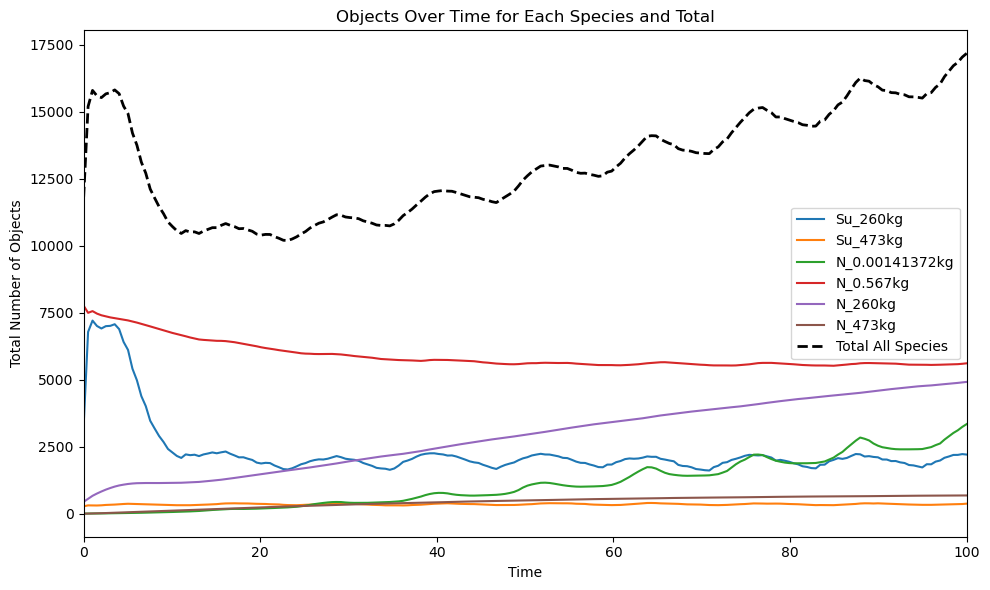

In [61]:
# Assuming scenario_properties.species_names is available
import matplotlib.pyplot as plt # type: ignore
species_names = scenario_properties.species_names

plt.figure(figsize=(10, 6))

# Assuming output.y's shape is (n_variables, n_time_points) and is ordered by species
num_species = len(species_names)
num_shells = 40  # Number of shells per species

# Initialize an array to hold the total number of objects at each time point
total_objects_all_species = np.zeros_like(output.t)

# Sum and plot for each species, using species names for labels
for i in range(num_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)  # Sum along the vertical axis
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    
    # Add to the total objects count
    total_objects_all_species += total_objects_per_species

# Plot the total sum line
plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))


plt.legend()
plt.tight_layout()
plt.show()


In [21]:
def population_shell(t, N, full_lambda, equations, scenario_properties):
    print(f"Time: {t}")
    dN_dt = np.zeros_like(N)

    if scenario_properties.time_dep_density:
        rho = JB2008_dens_func(t, h, density_data, date_mapping, nearest_altitude_mapping)
        rho_mat = np.tile(rho[:-1], (1, scenario_properties.species_length)) 
        rho_mat_kp1 = np.tile(rho[1:], (1, scenario_properties.species_length)) 

        # Evaluate drag terms, assuming they are defined as functions returning NumPy arrays
        drag_upper_with_density = scenario_properties.drag_term_upper(N) * rho_mat_kp1
        drag_cur_with_density = scenario_properties.drag_term_cur(N) * rho_mat
        full_drag = drag_upper_with_density + drag_cur_with_density

        dN_dt += np.sum(full_drag, axis=0)  # Sum along axis if needed, and ensure it's flattened correctly

    for i in range(len(N)):
        if full_lambda[i] is not None:
            increase = np.interp(t, times, full_lambda[i])
            dN_dt[i] += 0 if np.isnan(increase) else increase
        dN_dt[i] += equations[i](*N)

    return dN_dt

# Assuming full_lambda_flattened and equations are provided correctly
output = solve_ivp(
    lambda t, N: population_shell(t, N, full_lambda_flattened, equations, scenario_properties),
    [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]],
    x0_flattened,
    t_eval=scenario_properties.scen_times,
    method='BDF'
)

Time: 0.0


TypeError: 'MutableDenseMatrix' object is not callable